## Size vs. Intensity (Figure 5)

In [1]:
# Import modules
import sys, h5py
import numpy as np
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Configuration
simulation_shape = (20, 80*300)
simulation_grid_shape = (80,300)
simulation_x = np.arange(0,300)
simulation_y = np.logspace(15,19,80) * (1000 * 50e-15) / 1e8
simulation_X, simulation_Y = np.meshgrid(simulation_x, simulation_y)
wavelength  = 0.22621e-9 #[m]
pulse_length = 50e-15 #[s]

In [3]:
# I/O settings
plotdir = '/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/'

### 1. Loading data from file

In [4]:
results_filename = '../meta/results.h5'
with h5py.File(results_filename, 'r') as f:
    diameter  = f['diameter'][:]
    intensity = f['intensity'][:]
    centerx   = f['centerx'][:]
    centery   = f['centery'][:]
    hitscore  = f['npeaks'][:]
    time      = f['time_s'][:]
    injectorx = f['injector_posx'][:]
    injectorz = f['injector_posz'][:]

In [5]:
simulation_filename = '../meta/sphere_simulation.h5'
with h5py.File(simulation_filename, 'r') as f:
    simulation_hitscore = f['results']['npeaks'][:].reshape(simulation_shape)
simulation_hitscore = simulation_hitscore.mean(axis=0).reshape(simulation_grid_shape)

### 2. Units and detection limits

In [6]:
# Fit detection limit using polynomials
detection_limit_y1 = simulation_Y[:,:48][(simulation_hitscore[:,:48] > 600-20) & (simulation_hitscore[:,:48] < 600+20)]
detection_limit_x1 = simulation_X[:,:48][(simulation_hitscore[:,:48] > 600-20) & (simulation_hitscore[:,:48] < 600+20)]
detection_limit_p1 = np.poly1d(np.polyfit(detection_limit_x1, detection_limit_y1, 8))
detection_limit_y2 = simulation_Y[:,45:80][(simulation_hitscore[:,45:80] > 600-20) & (simulation_hitscore[:,45:80] < 600+20)]
detection_limit_x2 = simulation_X[:,45:80][(simulation_hitscore[:,45:80] > 600-20) & (simulation_hitscore[:,45:80] < 600+20)]
detection_limit_p2 = np.poly1d(np.polyfit(detection_limit_x2, detection_limit_y2, 3))
detection_limit_y3 = simulation_Y[:,75:][(simulation_hitscore[:,75:] > 600-20) & (simulation_hitscore[:,75:] < 600+20)]
detection_limit_x3 = simulation_X[:,75:][(simulation_hitscore[:,75:] > 600-20) & (simulation_hitscore[:,75:] < 600+20)]
detection_limit_p3 = np.poly1d(np.polyfit(detection_limit_x3, detection_limit_y3, 6))
detection_limit = detection_limit_p1(simulation_x) * (simulation_x <= 43) + detection_limit_p2(simulation_x) * ((simulation_x > 43) & (simulation_x <= 79)) + detection_limit_p3(simulation_x) * (simulation_x > 79)

# Correct for detector efficiency
intensity *= (1./0.955)

# Intensity in Nr. of photons
h = 6.62606957e-34 #Js
c = 299792458 #m/s
hc = h*c  #Jm
intensity_NrPhum2 = ((intensity / 1000.) * wavelength) / (hc)
intensity_NrPh    = intensity_NrPhum2 * np.pi * (1e-3*diameter/2.)**2
intensity = intensity_NrPhum2
simulation_y = ((simulation_y / 1000.) * wavelength) / (hc) 
simulation_Y = ((simulation_Y / 1000.) * wavelength) / (hc) 

### 3. Heatmap and histograms

In [7]:
# Heatmap
bins_diameter  = np.hstack([simulation_x[::4], simulation_x[-1]+1])
bins_intensity = np.logspace(9,13,75)
bin_array = [bins_diameter, bins_intensity]

# Histogram of diameter
diameter_good = diameter[(diameter>30) & (intensity>simulation_y[20])]
hist_diameter, edges_diameter = np.histogram(diameter_good, range=(0,300), bins=100, density=False)

# Histogram of diameter (red)
diameter_good_red = diameter[(intensity>6e10)]# & (intensity<2e-1)]
hist_diameter_red, edges_diameter_red = np.histogram(diameter_good_red, range=(0,300), bins=150, density=False)

# Histogram of intensity/diameter (green)
diameter_good_green = diameter[(diameter > 0) & (diameter < 60) & (intensity>6e-2)]
intensity_good_green = intensity[(diameter > 0) & (diameter < 60) & (intensity>6e-2)]
hist_diameter_green, edges_diameter_green = np.histogram(diameter_good_green, range=(0,60), bins=30, density=False)
hist_intensity_green, edges_intensity_green = np.histogram(intensity_good_green, bins=bins_intensity[::2])

### 4. Plotting

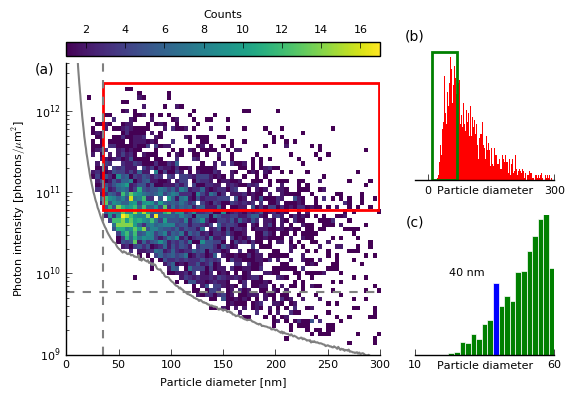

In [8]:
plot = plotting.Plot(fontsize=8, cols=3, rows=2, exclude=[0,1,3,4], border_in=0.25, colorbar=False, legend=False, 
                     legend_location=1, save_pdf=True)
plot.add_axes((0,0), 2,2, hfrac=0.93)
plot.add_axes((0,0), 2,1, pady=0.762, hfrac=0.1)
plot.title_label = 4*['']
plot.xlabel = [r'Particle diameter'] + [r'Particle diameter'] + [r'Particle diameter [nm]'] + ['']
plot.ylabel = 2*[''] + [r'Photon intensity [photons$/\mu$m$^2$]'] + ['']
plot.colorbar_label = r'Counts'

plot.plotting_a_heatmap(2, diameter, intensity, [(0,300),(1e9, simulation_y.max())], bins=bin_array, 
                        cmaplist=['viridis'], under='w', vmin=1, cax=plot.axes[3], 
                        colorbar_orientation='horizontal', colorbar=True)
plot.plotting_a_contour(2, simulation_X, simulation_Y, simulation_hitscore,
                        (600,), colors='0.5', linewidths=1.5, label=False)
plot.axes[2].axvline(35, color='0.5', linestyle='--', linewidth=1.5)
plot.axes[2].axhline(simulation_y[20], color='0.5', linestyle='--', linewidth=1.5)
plot.plotting_a_rectangle(2, 35, 6e10, 264, 2.2e12, edgecolor='r', facecolor='none', alpha=1, linewidth=2)
plot.axes[2].spines['top'].set_visible(False)
plot.axes[2].spines['right'].set_visible(False)
plot.axes[2].semilogy()
plot.axes[2].set_ylim([1e9,4e12])
plot.axes[2].text(-30,4e12,'(a)', va='top', ha='left', fontsize=10)
plot.axes[2].tick_params(axis='x', which='both', top='off', bottom='on', labeltop='off', labelbottom='on')
plot.axes[2].tick_params(axis='y', which='both', left='on', right='off', labelleft='on', labelright='off')


plot.axes[3].set_ylabel('')
plot.axes[3].set_xlabel(r'Counts', fontsize=8)
plot.axes[3].xaxis.set_label_position('top')
plot.axes[3].tick_params(axis='x', which='both', top='on', bottom='off', labeltop='on', labelbottom='off')

plot.plotting_a_histogram(0,hist_diameter_red, edges_diameter_red, xlim=(-30,300), type='bar',
                          edgewidth=0, color=['r'], label=['Histogram'], logx=False, logy=False)
plot.plotting_a_rectangle(0, 10, 0.1, 60, 55, edgecolor='g', facecolor='none', linewidth=2)
plot.axes[0].tick_params(axis='y', which='both', left='off', right='off', labelleft='off', labelright='off')
plot.axes[0].tick_params(axis='x', which='both', top='off', bottom='on', labeltop='off', labelbottom='on')
plot.axes[0].xaxis.set_label_position('bottom')
plot.axes[0].xaxis.labelpad = -7
plot.axes[0].text(-30,65,'(b)', va='top', ha='center', fontsize=10)
plot.axes[0].spines['top'].set_visible(False)
plot.axes[0].spines['left'].set_visible(False)
plot.axes[0].spines['right'].set_visible(False)
plot.axes[0].set_xticks([0,300])

colors = len(edges_diameter_green) * ['g']
colors[19] = 'b'
plot.plotting_a_histogram(1,hist_diameter_green, edges_diameter_green, xlim=(10,60), ylim=[0,100], type='bar',
                          edgewidth=0.5, color=[colors], label=['Histogram'], logx=False, logy=False)
plot.axes[1].tick_params(axis='y', which='both', left='off', right='off', labelleft='off', labelright='off')
plot.axes[1].tick_params(axis='x', which='both', top='off', bottom='on', labeltop='off', labelbottom='on')
plot.axes[1].text(10,100,'(c)', va='top', ha='center', fontsize=10)
plot.axes[1].xaxis.labelpad = -7
plot.axes[1].spines['top'].set_visible(False)
plot.axes[1].spines['left'].set_visible(False)
plot.axes[1].spines['right'].set_visible(False)
plot.axes[1].set_xticks([10,60])
plot.axes[1].text(35,55,r'40 nm', fontsize=8, ha='right', va='bottom')

#plot.save(plotdir + 'fig_size_vs_intensity_heatmap.pdf')
plot.show()

**Figure 5.**
Classification of hits based on fitting to sphere diffraction model.                                                                                                      
(a) Distribution of particle sizes and incident photon intensities shown as a 2D histogram.                                                                                        
The solid/dashed gray lines indicates the same detection/classification limits as described in Figure 2.                                                        
The size of a diameter bin was chosen to be $4$~nm, while                                                                                                                          
in the intensity direction, $75$ bins have been logarithmically distributed between $10^9$ and $10^{13}$ photons/$\mu$m$^2$.                                                       
(b) Overall distribution of particle sizes (integrated inside the red rectangle                                                                                                    
along the vertical direction) with a bin size of $2$~nm.                                                                                                                          
(c) A zoomed in region of the same size distribution as shown in (b) around the                                                                                                    
expected particle size of ${\sim}40$~nm. 